Proton normalization (dN/dE prefactor) = 7.230e+47 [1/GeV]
Flare peak at t = 0.0 days
Expected gamma counts in 6.0 days (VERITAS-like placeholder): 3.459e-05


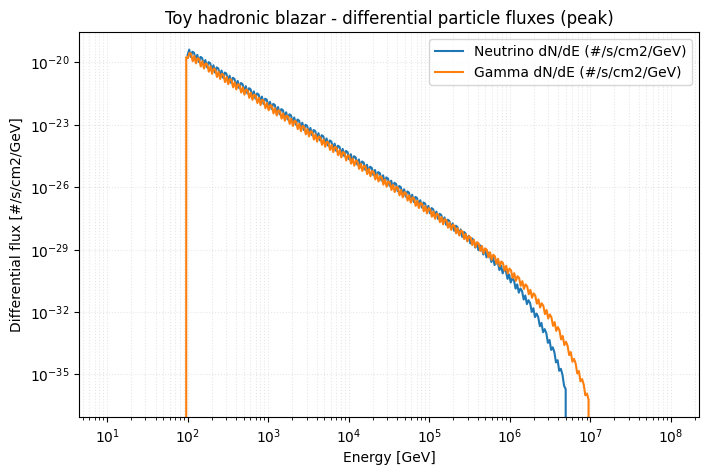

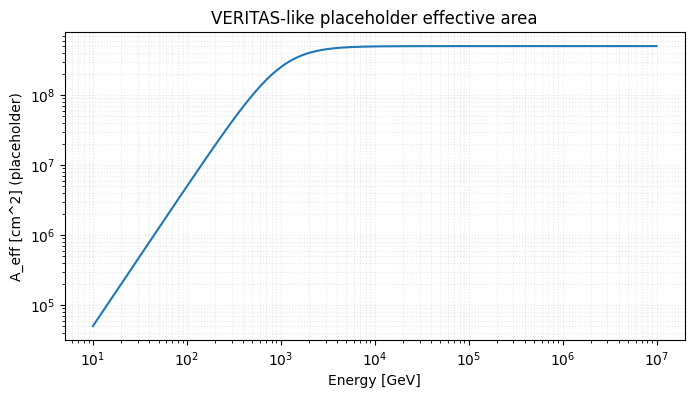

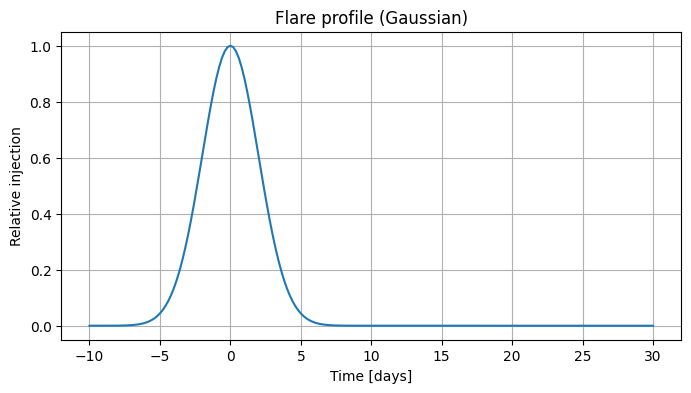

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from astropy import units as u
from astropy.constants import c, m_p
from math import erf

#---------------------------
# Model Parameters
#---------------------------

# Proton Spectrum
s = 2.0                     # Proton Spectral Index ( E**(-s) How steeply number of protons decrease with Energy)
E_p_min = 1e3               # GeV (1 TeV) 
E_p_max = 1e8               # GeV (100 PeV) 
E_p_cut = 1e7               # GeV, (At High Energies, Radiative Loss Dominates)
E0 = 1e6                    # GeV, Reference Energy (For Specifying the PhotoHadronic Interaction efficiency before applying the Energy Scaling)

# Proton Luminosity (isotropic equivalent) - We assume the source radiated the same amount in all directions. 
Lp_erg_s = 1e46             # erg/s

# pγ (Photo Hadronic) Interaction Efficiency Parameters (parametrized)
f0 = 1e-3                   # the base pγ efficiency at reference energy E0 (dimensionless quantity).
beta = 0.5                  # energy dependence exponent (Tells us how quickly the interaction efficiency increases with proton energy)
kappa = 0.2                 # inelasticity; fraction of proton energy that becomes pion energy. 

# Pion partition (approx); the experiementally measured branching ratios.
chi_charged = 2/3.0         # charged pion fraction
chi_neutral = 1/3.0         # neutral pion fraction

# Geometry / Distance
z = 0.03                    # example redshift (~130 Mpc)
H0 = 70                     # km/s/Mpc
c_km_s = 2999792.458
d_Mpc = (c_km_s/H0) * z     # Mpc
D_L_cm = (d_Mpc * 3.085677581e24)  # convert Mpc -> cm

# Time / flare
t_center = 0.0
t_sigma = 2.0
t_eval = np.linspace (-10, 30, 201) # days

# Energies to evaluate spectra
E_p_grid = np.logspace(np.log10(E_p_min), np.log10(E_p_max), 400)  # Creates 400 Values between E_p_min and E_p_max (GeV).
E_nu_grid = np.logspace(2, 8, 300) # Creates 300 values between 10**2 and 10**8 GeV (0.1 TeV to 100 PeV).
E_gamma_grid = np.logspace(1, 7, 300)  # 100 GeV – 10 TeV

# Conversion factor from GeV to erg
GeV_to_erg = 1.602176634e-3  


#---------------------------------
# Proton Injection Spectrum dN/dE
#---------------------------------

def proton_spectrum(Ep, norm=1.0):
    """dN/dE_p [1/GeV] unnormalized power law with exp cutoff"""
    return norm * Ep**(-s) * np.exp(-Ep/E_p_cut)

# Compute Normalization so that integral Ep * dN/dE * dE = Lp (in erg/s)
def compute_proton_norm(Lp_erg_s):
    """Return normalization N0 such that total proton luminosity = Lp."""
    integrand = E_p_grid * proton_spectrum(E_p_grid, norm=1.0)

    # numerical integral over energy
    integral = simpson(integrand, x=E_p_grid)

    # convert GeV luminosity to erg/s
    norm = Lp_erg_s / (integral * GeV_to_erg)
    return norm


# PhotoHadronic interaction efficiency (parametrized)
def f_pgamma(Ep):
    """Returns a number between 0 and 1(efficiency). Ep in Gev."""
    val = f0 * (Ep/E0)**beta
    return np.minimum(val, 1.0) # array of values, with all values greater than 1 are now equal to 1.

# Pion energy injection
norm_p = compute_proton_norm(Lp_erg_s)
print(f"Proton normalization (dN/dE prefactor) = {norm_p:.3e} [1/GeV]")

dNpdE = proton_spectrum(E_p_grid, norm=norm_p)

pion_energy_rate_per_Ep = E_p_grid * dNpdE * f_pgamma(E_p_grid) * kappa

# This function maps a physical spectrum defined on one energy grid onto a new energy grid.
def map_spectrum(E_source_grid, target_grid, mapping_factor, source_spec):
    m = mapping_factor
    Et_arr = m * E_source_grid
    target_vals = np.zeros_like(target_grid)
    for i, Et in enumerate(Et_arr):
        idx = np.searchsorted(target_grid, Et)
        if idx == 0 or idx >= len(target_grid):
            continue
        target_vals[idx-1] += source_spec[i]
    return target_vals

# Map to neutrino/gamma energy injection
neutrino_energy_inj = map_spectrum(E_p_grid, E_nu_grid, 0.05, pion_energy_rate_per_Ep * chi_charged)
gamma_energy_inj    = map_spectrum(E_p_grid, E_gamma_grid, 0.1,  pion_energy_rate_per_Ep * chi_neutral)

dE_nu = np.gradient(E_nu_grid)
dE_gamma = np.gradient(E_gamma_grid)
dL_dE_nu    = neutrino_energy_inj / dE_nu * GeV_to_erg
dL_dE_gamma = gamma_energy_inj    / dE_gamma * GeV_to_erg

flux_nu    = dL_dE_nu    / (4 * np.pi * D_L_cm**2)
flux_gamma = dL_dE_gamma / (4 * np.pi * D_L_cm**2)

dNdE_nu    = dL_dE_nu    / (E_nu_grid * GeV_to_erg) / (4 * np.pi * D_L_cm**2)
dNdE_gamma = dL_dE_gamma / (E_gamma_grid * GeV_to_erg) / (4 * np.pi * D_L_cm**2)

# ---------------------------
# Time dependence (flare)
# ---------------------------
def flare_profile(t_days):
    return np.exp(-0.5 * ((t_days - t_center)/t_sigma)**2)

t_index = np.argmax(flare_profile(t_eval))
print(f"Flare peak at t = {t_eval[t_index]} days")

obs_start = -2.0
obs_stop  = 4.0
obs_mask  = (t_eval >= obs_start) & (t_eval <= obs_stop)
obs_duration_days = (obs_stop - obs_start)
obs_duration_s    = obs_duration_days * 86400.0

# ---------------------------
# VERITAS-like effective area
# ---------------------------
def example_Aeff(E_GeV):
    E0_A = 1e3
    A_max = 5e8  # cm² (5,000,000 m²)

    return A_max * ( (E_GeV/E0_A)**2 / (1 + (E_GeV/E0_A)**2) )

Aeff_gamma = example_Aeff(E_gamma_grid)

N_gamma_expected = simpson(dNdE_gamma * Aeff_gamma, E_gamma_grid) * obs_duration_s

print(f"Expected gamma counts in {obs_duration_days:.1f} days (VERITAS-like placeholder): {N_gamma_expected:.3e}")

# ---------------------------
# Plot results
# ---------------------------
plt.figure(figsize=(8,5))
plt.loglog(E_nu_grid, dNdE_nu, label='Neutrino dN/dE (#/s/cm2/GeV)')
plt.loglog(E_gamma_grid, dNdE_gamma, label='Gamma dN/dE (#/s/cm2/GeV)')
plt.xlabel("Energy [GeV]")
plt.ylabel("Differential flux [#/s/cm2/GeV]")
plt.legend()
plt.title("Toy hadronic blazar - differential particle fluxes (peak)")
plt.grid(True, which='both', ls=':', alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.loglog(E_gamma_grid, Aeff_gamma)
plt.xlabel("Energy [GeV]")
plt.ylabel("A_eff [cm^2] (placeholder)")
plt.title("VERITAS-like placeholder effective area")
plt.grid(True, which='both', ls=':', alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t_eval, flare_profile(t_eval))
plt.xlabel("Time [days]")
plt.ylabel("Relative injection")
plt.title("Flare profile (Gaussian)")
plt.grid(True)
plt.show()
